In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd, glob, re, string,seaborn as sns
from nltk.corpus import stopwords
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,f1_score,precision_recall_fscore_support,log_loss
from sklearn.linear_model import Lasso, SGDClassifier,LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras.backend as K
import tensorflow as tf
from keras import layers, losses
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping,TensorBoard
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut, KFold,cross_val_score
#import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from numpy import mean
from matplotlib import pyplot
from tqdm import tqdm


C:\Users\LaptopCheckout\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LaptopCheckout\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LaptopCheckout\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Create DataFrames**

In [7]:
def clean_text(text,stop_words=True, normalization=True):
    cleaned_text = text.lower()
    cleaned_text = "".join(c for c in cleaned_text if c not in string.punctuation)
    cleaned_text = "".join(c for c in cleaned_text if ord(c)<128)
    words = cleaned_text.split()
    if normalization == True:
      if stop_words==True:
          words = [w for w in words if w not in stopwords.words("english")]
      lem = WordNetLemmatizer()
      words = [lem.lemmatize(word, "v") for word in words]
      words = [lem.lemmatize(word, "n") for word in words]
    cleaned_text = " ".join(words)
    return cleaned_text
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    return df

In [6]:
path = r'C:/Users/LaptopCheckout/Downloads/LegalArgumentMining/'
df_train = create_dataframe(path + "Train_data")
df_test = create_dataframe(path + "test_data")
df_unlabelled = create_dataframe(path + "Unlabeled_data")
df_train.head()

,Sentence,Target
0,Appellant had stated to the officers that she ...,Invalid
1,We shall discuss the facts more fully in conne...,Others
2,"â€œPerjury is a false statement, either writte...",Invalid
3,The offense is felony theft by false pretext; ...,Issue
4,Numerous contentions urging the commission of ...,Issue


In [8]:
df_test = create_dataframe(path + "test_data")
df_test.head()

,Sentence,Target
0,Darden Sr. testified â€œI saw he was staggerin...,Facts
1,Additional moral justification may have been d...,Analysis
2,"85, 22 S.W. 140, wherein the accused was actin...",Rule/Law/Holding
3,Under a proper instruction from the court on m...,Facts
4,He is eligible for leaves to renew contacts wi...,Facts


Analysis on length of all the sentences in the train set

<AxesSubplot:>

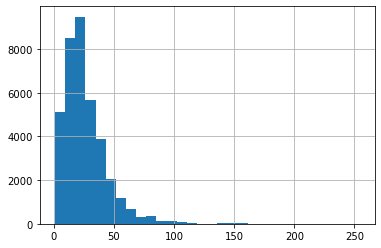

In [9]:
pd.Series([len(i.split()) for i in df_train['Sentence']]).hist(bins = 30)

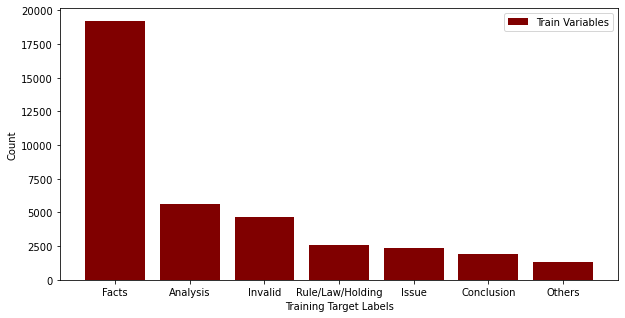

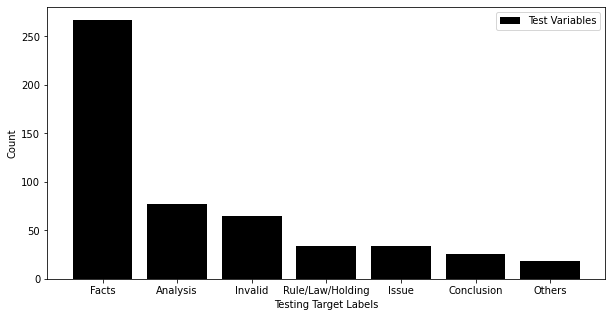

In [10]:
#plot bar graphs of df_train and df_test
import matplotlib.pyplot as plt  
# creating the dataset 
data = df_train['Target'].value_counts()
keys = list(data.keys()) 
values = list(data.values) 
data1 = df_test['Target'].value_counts()
keys1 = list(data1.keys()) 
values1 = list(data1.values)    
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot 
plt.bar(keys, values, color ='maroon',label ='Train Variables')  
plt.xlabel("Training Target Labels") 
plt.ylabel("Count") 
plt.legend()
plt.show()
plt.figure(figsize = (10, 5)) 
plt.bar(keys1, values1, color ='black',label ='Test Variables')
plt.xticks(keys)    
plt.xlabel("Testing Target Labels") 
plt.ylabel("Count") 
plt.legend()
plt.show()

**Label Encoding Dependent Variable**

In [11]:
l = LabelEncoder().fit(df_train['Target'])
df_train['Target'] = l.transform(df_train['Target'])
df_test['Target'] = l.transform(df_test['Target'])
df_train.head()

,Sentence,Target
0,Appellant had stated to the officers that she ...,3
1,We shall discuss the facts more fully in conne...,5
2,"â€œPerjury is a false statement, either writte...",3
3,The offense is felony theft by false pretext; ...,4
4,Numerous contentions urging the commission of ...,4


**Clean Text and no Normalization**

In [12]:
df_train['Sentence'] = df_train['Sentence'].apply(clean_text, normalization=False)
df_test['Sentence'] = df_test['Sentence'].apply(clean_text, normalization=False)

**Cleaned and Normalized Text**

In [13]:
df_train['Normalized_Sentence'] = df_train['Sentence'].apply(clean_text)
df_test['Normalized_Sentence'] = df_test['Sentence'].apply(clean_text)

1. Word Embedding with Tf-Idf
2. Word Embedding with Word2Vec
3. Word Embedding with BERT

**Word Embedding with Tf-Idf**

In [14]:
def data2tfidf(data1,data2,pca=False):
  t= TfidfVectorizer().fit(data1['Normalized_Sentence'])
  x, test_x = t.transform(data1['Normalized_Sentence']).toarray(), t.transform(data2['Normalized_Sentence']).toarray()
  y, test_y = data1['Target'], data2['Target']
  if pca:
    pcas = PCA(500).fit(x)
    x, test_x = pcas.transform(x), pcas.transform(test_x)
  train_x,val_x, train_y, val_y = train_test_split(x,y, stratify=y, test_size=0.2)
  return train_x,train_y,val_x,val_y, test_x,test_y

train_x,train_y,val_x,val_y, test_x,test_y = data2tfidf(df_train,df_test,pca=500)
train_x.shape,train_y.shape,val_x.shape,val_y.shape, test_x.shape,test_y.shape

((30168, 500), (30168,), (7543, 500), (7543,), (521, 500), (521,))

1. Logistic Regression
2. Decision Trees
3. Random Forests
4. Gradient Boosting
5. XGBoosting
6. Light Boosting
7. Ada Boosting
8. Ridge Classification

# Random Forests

In [22]:
rf= RandomForestClassifier(n_estimators = 350, criterion = 'gini', random_state = 42)
rf.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,rf.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,rf.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,rf.predict(test_x)))

Training Accuracy is 0.9939008220631133
Validation Accuracy is 0.9863449555879623
Testing Accuracy is 0.6065259117082533


In [ ]:
parameter_grid = {'max_depth' : [4,5,6,7,9],'max_features': [0.5, 0.7, 0.9]}
rf= RandomForestClassifier(n_estimators = 350, criterion = 'gini', random_state = 42)
cv = KFold(n_splits=10, shuffle=True, random_state=101)
gridsearch = GridSearchCV(estimator=rf, param_grid=parameter_grid, scoring='accuracy', cv=cv)
gridsearch.fit(train_x,train_y)
m = gridsearch.best_estimator_
print(m)
m.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,m.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,m.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,m.predict(test_x)))

# LGBoost

In [24]:
params = {'n_estimators': 365, 'n_jobs': -1, 'random_state': 2, 'learning_rate': 0.014564209621859385, 'colsample_bytree': 0.48762749309989595 }
lgbm=LGBMClassifier(**params)
lgbm.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,lgbm.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,lgbm.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,lgbm.predict(test_x)))

Training Accuracy is 0.989724211084593
Validation Accuracy is 0.9798488664987406
Testing Accuracy is 0.6257197696737045


In [ ]:
parameter_grid = {'learning_rate' : [ 0.0001,0.001,0.01,0.1,1,10]}
lgbm= LGBMClassifier(n_estimators = 365, n_jobs= -1, random_state= 2, colsample_bytree= 0.48762749309989595)
cv = KFold(n_splits=10, shuffle=True, random_state=101)
gridsearch = GridSearchCV(estimator=lgbm, param_grid=parameter_grid, scoring='accuracy', cv=cv)
gridsearch.fit(train_x,train_y)
m = gridsearch.best_estimator_
print(m)
m.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,m.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,m.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,m.predict(test_x)))

# XGBoost

In [23]:
xgb =  XGBClassifier(random_state=101,learning_rate=0.1, reg_alpha=0, reg_lambda=0,booster='gblinear')
xgb.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,xgb.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,xgb.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,xgb.predict(test_x)))

C:\Users\LaptopCheckout\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy is 0.8269026783346592
Validation Accuracy is 0.8047196075831897
Testing Accuracy is 0.6199616122840691


In [ ]:
parameter_grid = {'learning_rate' : [ 0.0001,0.001,0.01,0.1,1,10]}
xgb= XGBClassifier(random_state=101,learning_rate=0.1, reg_alpha=0, reg_lambda=0,booster='gblinear')
cv = KFold(n_splits=10, shuffle=True, random_state=101)
gridsearch = GridSearchCV(estimator=xgb, param_grid=parameter_grid, scoring='accuracy', cv=cv)
gridsearch.fit(train_x,train_y)
m = gridsearch.best_estimator_
print(m)
m.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,m.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,m.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,m.predict(test_x)))

# LinearSVC

In [26]:
lsvc= LinearSVC(C=100)
lsvc.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,lsvc.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,lsvc.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,lsvc.predict(test_x)))

Training Accuracy is 0.8419185892336251
Validation Accuracy is 0.8215564099164788
Testing Accuracy is 0.5834932821497121


C:\Users\LaptopCheckout\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
parameter_grid = {'penalty':['l1', 'l2'],'loss':['hinge', 'squared_hinge'],'multi_class':['ovr', 'crammer_singer']
                 ,'C':[1,10,100]}
lsvc= LinearSVC()
cv = KFold(n_splits=10, shuffle=True, random_state=101)
gridsearch = GridSearchCV(estimator=lsvc, param_grid=parameter_grid, scoring='accuracy', cv=cv)
gridsearch.fit(train_x,train_y)
m = gridsearch.best_estimator_
print(m)
m.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,m.predict(train_x)))
print('Validation Accuracy is',accuracy_score(val_y,m.predict(val_x)))
print('Testing Accuracy is',accuracy_score(test_y,m.predict(test_x)))

In [ ]:
lsvc= LinearSVC()
cv = KFold(n_splits=10, shuffle=True, random_state=101)
m = cross_val_score(lsvc, train_x,train_y,scoring='accuracy', cv=cv, n_jobs=-1)
m

In [29]:
def get_models(a=0,b=None):
    models = [LogisticRegression(),RidgeClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),BaggingClassifier(),
              GradientBoostingClassifier(),XGBClassifier(),LGBMClassifier(),AdaBoostClassifier(),ExtraTreeClassifier(),ExtraTreesClassifier(),
              KNeighborsClassifier(),LinearSVC(),SVC(),SGDClassifier(),GaussianNB(),GaussianProcessClassifier(),
              LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),PassiveAggressiveClassifier()]
    train_accuracy,val_accuracy,test_accuracy = [], [], []
    if not b:
      b=len(models)
    l = models[a:b]
    for m in tqdm(l):
        m.fit(train_x, train_y)
        train_accuracy.append(accuracy_score(train_y,m.predict(train_x)))
        val_accuracy.append(accuracy_score(val_y,m.predict(val_x)))
        test_accuracy.append(accuracy_score(test_y,m.predict(test_x)))
    data = pd.DataFrame({'Model':[str(i)[:-2] for i in l],'Training Accuracy':train_accuracy,'Validation Accuracy':val_accuracy,
                        'Testing Accuracy':test_accuracy})
    return data
data1=get_models(0,3)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\LaptopCheckout\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.75s/it]


In [30]:
model_dict = {'RandomForestClassifier':rf,'XGBoostClassifier':xgb,'LightGBM':lgbm,'LinearSVC(C=100)':lsvc}
train_accuracy,val_accuracy,test_accuracy = [], [], []
for mn,m in tqdm(model_dict.items()):
        train_accuracy.append(accuracy_score(train_y,m.predict(train_x)))
        val_accuracy.append(accuracy_score(val_y,m.predict(val_x)))
        test_accuracy.append(accuracy_score(test_y,m.predict(test_x)))
data = pd.DataFrame({'Model':[str(mn) for mn in model_dict.keys()],'Training Accuracy':train_accuracy,'Validation Accuracy':val_accuracy,
                        'Testing Accuracy':test_accuracy})

data.append(data1)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.96s/it]
C:\Users\LaptopCheckout\AppData\Local\Temp\ipykernel_21668\2573618633.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data.append(data1)


,Model,Training Accuracy,Validation Accuracy,Testing Accuracy
0,RandomForestClassifier,0.993901,0.986345,0.606526
1,XGBoostClassifier,0.826903,0.804720,0.619962
2,LightGBM,0.989724,0.979849,0.625720
3,LinearSVC(C=100),0.841919,0.821556,0.583493
0,LogisticRegression,0.782650,0.766671,0.648752
1,RidgeClassifier,0.741382,0.728490,0.625720
2,DecisionTreeClassifier,0.993967,0.985550,0.477927


Due to Time Constraints, we only perform Cross Validation and Hyper Parameter Tuning for ML Models having higher accuracies, generalised from the above report

# Neural Networks

In [31]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model = tf.keras.Sequential([
    layers.Dense(500,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(250,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(6,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(7,activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.build((train_x.shape[0], 500))
model.summary()
epochs = 10
callbacks=[ReduceLROnPlateau()]
history = model.fit(train_x,train_y,epochs=10,batch_size=50,callbacks=callbacks, validation_data=(val_x,val_y),shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (30168, 500)              250500    
                                                                 
 dropout (Dropout)           (30168, 500)              0         
                                                                 
 dense_1 (Dense)             (30168, 250)              125250    
                                                                 
 dropout_1 (Dropout)         (30168, 250)              0         
                                                                 
 dense_2 (Dense)             (30168, 6)                1506      
                                                                 
 dropout_2 (Dropout)         (30168, 6)                0         
                                                                 
 dense_3 (Dense)             (30168, 7)                4

In [32]:
model.evaluate(test_x,test_y)

17/17 [==============================] - 0s 3ms/step - loss: 2.9338 - accuracy: 0.6430


[2.933814287185669, 0.642994225025177]

In [33]:
data3 = pd.DataFrame({'Model':['Neural Networks (Epoch=10)'],'Training Accuracy':[0.9547],'Validation Accuracy':[0.9708],
                        'Testing Accuracy':[0.6429]})
data2=data.append(data1)
data4=data2.append(data3)
data4

C:\Users\LaptopCheckout\AppData\Local\Temp\ipykernel_21668\895577368.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data2=data.append(data1)
C:\Users\LaptopCheckout\AppData\Local\Temp\ipykernel_21668\895577368.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data4=data2.append(data3)


,Model,Training Accuracy,Validation Accuracy,Testing Accuracy
0,RandomForestClassifier,0.993901,0.986345,0.606526
1,XGBoostClassifier,0.826903,0.804720,0.619962
2,LightGBM,0.989724,0.979849,0.625720
3,LinearSVC(C=100),0.841919,0.821556,0.583493
0,LogisticRegression,0.782650,0.766671,0.648752
1,RidgeClassifier,0.741382,0.728490,0.625720
2,DecisionTreeClassifier,0.993967,0.985550,0.477927
0,Neural Networks (Epoch=10),0.954700,0.970800,0.642900


**Random Forest**

In [ ]:
rf= RandomForestClassifier(n_estimators = 350, criterion = 'gini', max_features = 'auto', random_state = 42)
rf.fit(train_x,train_y)

RandomForestClassifier(n_estimators=350, random_state=42)

In [ ]:
accuracy_score(test_y,rf.predict(test_x))

0.6122840690978887

**XGBoost**

In [ ]:
xgb =  XGBClassifier(random_state=101,learning_rate=0.1, reg_alpha=0, reg_lambda=0,booster='gblinear')
xgb.fit(train_x,train_y)

XGBClassifier(booster='gblinear', objective='multi:softprob', random_state=101,
              reg_lambda=0)

In [ ]:
accuracy_score(test_y,xgb.predict(test_x))

0.6276391554702495

In [ ]:
from  sklearn import linear_model
clf = linear_model.LogisticRegressionCV()
clf.fit(train_x,train_y)
accuracy_score(test_y,clf.predict(test_x))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6046065259117083

In [ ]:
accuracy_score(train_y,xgb.predict(train_x))

0.8296870856536728

**XGB + Logistic**

In [ ]:
from sklearn.linear_model import LogisticRegression as LR , ElasticNetCV as EC, RidgeClassifier as RC, Lasso
from sklearn.metrics import roc_auc_score as roc ,roc_curve, auc
lr =LR()
lr.fit(train_x,train_y)
las ,rdge = Lasso(), RC()
las.fit(train_x,train_y)
rdge.fit(train_x,train_y)
accuracy_score(test_y,lr.predict(test_x))
#accuracy_score(test_y,las.predict(test_x))
accuracy_score(test_y,rdge.predict(test_x))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6487523992322457

**Finding Optimal K value for K-Fold Cross Validation, we chose k=10**

  3%|▎         | 1/29 [00:36<17:04, 36.57s/it]

> folds=2, accuracy=0.750 (0.748,0.752)


  7%|▋         | 2/29 [01:14<16:49, 37.40s/it]

> folds=3, accuracy=0.763 (0.757,0.769)


 10%|█         | 3/29 [01:50<15:53, 36.67s/it]

> folds=4, accuracy=0.764 (0.759,0.772)


 14%|█▍        | 4/29 [02:39<17:21, 41.66s/it]

> folds=5, accuracy=0.767 (0.759,0.777)


 17%|█▋        | 5/29 [03:41<19:32, 48.87s/it]

> folds=6, accuracy=0.769 (0.758,0.776)


 21%|██        | 6/29 [04:55<22:00, 57.41s/it]

> folds=7, accuracy=0.769 (0.764,0.775)


 24%|██▍       | 7/29 [06:20<24:19, 66.34s/it]

> folds=8, accuracy=0.770 (0.760,0.780)


 28%|██▊       | 8/29 [08:01<27:06, 77.44s/it]

> folds=9, accuracy=0.770 (0.761,0.781)


 31%|███       | 9/29 [09:55<29:41, 89.08s/it]

> folds=10, accuracy=0.770 (0.759,0.784)


 34%|███▍      | 10/29 [11:49<30:35, 96.59s/it]

> folds=11, accuracy=0.771 (0.760,0.785)


 38%|███▊      | 11/29 [13:48<31:01, 103.42s/it]

> folds=12, accuracy=0.771 (0.756,0.785)


 41%|████▏     | 12/29 [15:59<31:39, 111.75s/it]

> folds=13, accuracy=0.773 (0.760,0.788)


 45%|████▍     | 13/29 [18:25<32:36, 122.30s/it]

> folds=14, accuracy=0.772 (0.760,0.784)


 48%|████▊     | 14/29 [21:09<33:44, 134.96s/it]

> folds=15, accuracy=0.772 (0.757,0.790)


 52%|█████▏    | 15/29 [23:59<33:54, 145.31s/it]

> folds=16, accuracy=0.773 (0.754,0.792)


 55%|█████▌    | 16/29 [27:00<33:51, 156.26s/it]

> folds=17, accuracy=0.773 (0.762,0.790)


 59%|█████▊    | 17/29 [30:05<32:56, 164.70s/it]

> folds=18, accuracy=0.772 (0.754,0.791)


 62%|██████▏   | 18/29 [33:29<32:24, 176.73s/it]

> folds=19, accuracy=0.773 (0.750,0.799)


 66%|██████▌   | 19/29 [36:59<31:06, 186.63s/it]

> folds=20, accuracy=0.772 (0.758,0.785)


 69%|██████▉   | 20/29 [40:41<29:35, 197.30s/it]

> folds=21, accuracy=0.773 (0.757,0.787)


 72%|███████▏  | 21/29 [44:47<28:13, 211.72s/it]

> folds=22, accuracy=0.773 (0.752,0.798)


 76%|███████▌  | 22/29 [48:52<25:53, 221.93s/it]

> folds=23, accuracy=0.773 (0.757,0.793)


 79%|███████▉  | 23/29 [52:57<22:52, 228.80s/it]

> folds=24, accuracy=0.773 (0.756,0.796)


 83%|████████▎ | 24/29 [57:13<19:44, 236.89s/it]

> folds=25, accuracy=0.773 (0.748,0.805)


 86%|████████▌ | 25/29 [1:01:38<16:21, 245.47s/it]

> folds=26, accuracy=0.773 (0.758,0.800)


 90%|████████▉ | 26/29 [1:06:22<12:51, 257.05s/it]

> folds=27, accuracy=0.773 (0.757,0.792)


 93%|█████████▎| 27/29 [1:11:11<08:53, 266.51s/it]

> folds=28, accuracy=0.774 (0.756,0.800)


 97%|█████████▋| 28/29 [1:16:18<04:38, 278.56s/it]

> folds=29, accuracy=0.774 (0.750,0.794)


100%|██████████| 29/29 [1:22:39<00:00, 171.00s/it]

> folds=30, accuracy=0.774 (0.753,0.796)


NameError: ignored

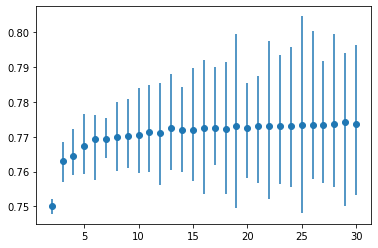

In [ ]:
def model_testing(cv):
    model = LogisticRegression()
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return mean(scores), scores.min(), scores.max()
folds = range(2,31)
means, mins, maxs = list(),list(),list()
for k in tqdm(folds):
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    k_mean, k_min, k_max = model_testing(cv,x,y)
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    means.append(k_mean)
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
pyplot.plot(folds, [i for i in range(len(folds))], color='r')
pyplot.show()

LGBM

In [ ]:
#params = {'n_estimators': 365, 'n_jobs': -1, 'random_state': 2, 'learning_rate': 0.014564209621859385, 'colsample_bytree': 0.48762749309989595}
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

lgbm = lgb.LGBMClassifier()
lgbm.fit(train_x,train_y)
accuracy_score(test_y,lgbm.predict(test_x))

0.6314779270633397

In [ ]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model = tf.keras.Sequential([
    layers.Dense(5757,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(1000,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(250,activation=tf.keras.layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(7,activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.build((train_x.shape[0], train_x.shape[1]))
model.summary()
epochs = 10
callbacks=[ReduceLROnPlateau()]
history = model.fit(train_x,train_y,epochs=10,batch_size=50,callbacks=callbacks, validation_data=(test_x, test_y),shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (37711, 5757)             33148806  
                                                                 
 dropout_3 (Dropout)         (37711, 5757)             0         
                                                                 
 dense_5 (Dense)             (37711, 1000)             5758000   
                                                                 
 dropout_4 (Dropout)         (37711, 1000)             0         
                                                                 
 dense_6 (Dense)             (37711, 250)              250250    
                                                                 
 dropout_5 (Dropout)         (37711, 250)              0         
                                                                 
 dense_7 (Dense)             (37711, 7)               

KeyboardInterrupt: ignored